# 데이터마이닝 프로젝트 - 남재현, 백민홍, 심지수

## 1. 전처리

### 1.1. Crawling을 통해 수집한 데이터를 하나로 묶습니다.

In [1]:
import pandas as pd
import os
import numpy as np

path="./book_info"
file_list=os.listdir(path)

csv_base='./book_info/{}'
csv=csv_base.format(file_list[0])
df_total=pd.read_csv(csv,encoding='utf-8')

for i in range(1,len(file_list)):
    csv=csv_base.format(file_list[i])
    df=pd.read_csv(csv,encoding='utf-8')
    df_total=pd.concat([df_total,df],axis=0).reset_index(drop=True)

### 1.2. title의 값이 null인 행을 제거합니다.

In [2]:
df_total=df_total.dropna(subset=['title'])

### 1.3. title이 중복된 값을 가질 경우 제거합니다.

In [3]:
df_total=df_total.drop_duplicates(['title'])
df_total=df_total.reset_index(drop=True)

### 1.4. introduction(책 소개)과 review(서평)가 모두 null인 행을 제거합니다. 따라서, 이제 적어도 하나의 text, 가능하다면 두 text를 모두 고려해서 모델링을 진행할 수 있습니다.

In [4]:
df_total=df_total.dropna(subset=['introduction','review'],how='all')

### 1.5. 나머지 null 값은 ''으로 대체합니다.

In [5]:
df_total=df_total.fillna('')
df_total=df_total.reset_index(drop=True)

### 1.6. 사용할 정보인 introduction과 review를 합쳐서 'text'라는 column에 정리합니다.

In [6]:
df_total['text']=df_total[['introduction','review']].apply(lambda x:' '.join(x),axis=1)

### 1.7. 모델 적용의 편의를 위해 정리한 dataframe을 'book_info(total).csv'로 내보냅니다.

In [7]:
df_total.to_csv('./book_info(total).csv',index=False,encoding='utf-8-sig')

## 2. TF-IDF Model

In [1]:
import gc
import konlpy
from konlpy.tag import Kkma,Okt,Komoran
from pprint import pprint
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics.pairwise import cosine_similarity

### 2.1. 'book_info(total).csv'를 불러온 후 input으로 넣을 string을 dataframe의 마지막 행에 추가합니다.

In [2]:
book=pd.read_csv('./book_info(total).csv',encoding='utf-8')
book.loc[len(book)]=['','','',0.0,'','','','','','{}'.format(input())]

히가시노


In [3]:
okt=Okt()

### 2.2. tokenize 및 vertorize

In [4]:
okt=Okt()
total_books=[]
book_content=book['text']

for books in book_content:
    pos_books=[','.join(t[:-1]) for t in okt.pos(books) if (t[1]=='Noun')]
    total_books.append(' '.join(pos_books))
    
kor_vectorizer = CountVectorizer()
kor_bow = kor_vectorizer.fit_transform(total_books)

### 2.3. TF-IDF 생성

In [5]:
transformer = TfidfTransformer()
tfidf = transformer.fit_transform(kor_bow.toarray())

### 2.4. input string과 가장 유사한 text를 가진 책의 title 5개 추출

In [6]:
def find_most_similar_book_idf(index, tfidf, book):
    idx = (-cosine_similarity(tfidf[index], tfidf)[0]).argsort()[1:6]
    return idx

idx=len(book)-1
idx=find_most_similar_book_idf(idx,tfidf,book)

for i in range(5):
    print(book.title[idx[i]])

추리소설가의 살인사건 超.殺人事件
라플라스의 마녀 히가시노 게이고 장편소설
그 시절 우리는 바보였습니다 히가시노 게이고 에세이
악의 가가 형사 시리즈
멘사 추리 퍼즐 1


## 3. Word2Vec Model

In [4]:
import pandas as pd
import nltk
from konlpy.tag import Okt
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

In [5]:
df_stop=pd.read_csv('./한국어불용어100.txt',sep='\t',header=None,
                   names=['stopword','else1','else2'])

In [6]:
stop_word=[df_stop['stopword'][i] for i in range(len(df_stop))]

### 3.1. tokenize 및 training set 생성

In [7]:
df=pd.read_csv('./book_info(total).csv')

okt=Okt()
x_train=[]
for sentence in df['text']:
    temp_x=[','.join(t[:-1]) for t in okt.pos(sentence) if ((t[1]=='Noun') & (t[0] not in stop_word))]
    x_train.append(temp_x)

### 3.2. Word2Vec Model 생성

In [8]:
from gensim.models import Word2Vec

model=Word2Vec(x_train,size=150,window=10,min_count=100,workers=4)

word_vectors=model.wv
vocabs=word_vectors.vocab.keys()
word_vectors_list=[word_vectors[v] for v in vocabs]

In [10]:
len(vocabs)

2055

### 3.3. 단어들 관계 시각화 및 확인

C:\Users\Nam\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\Nam\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


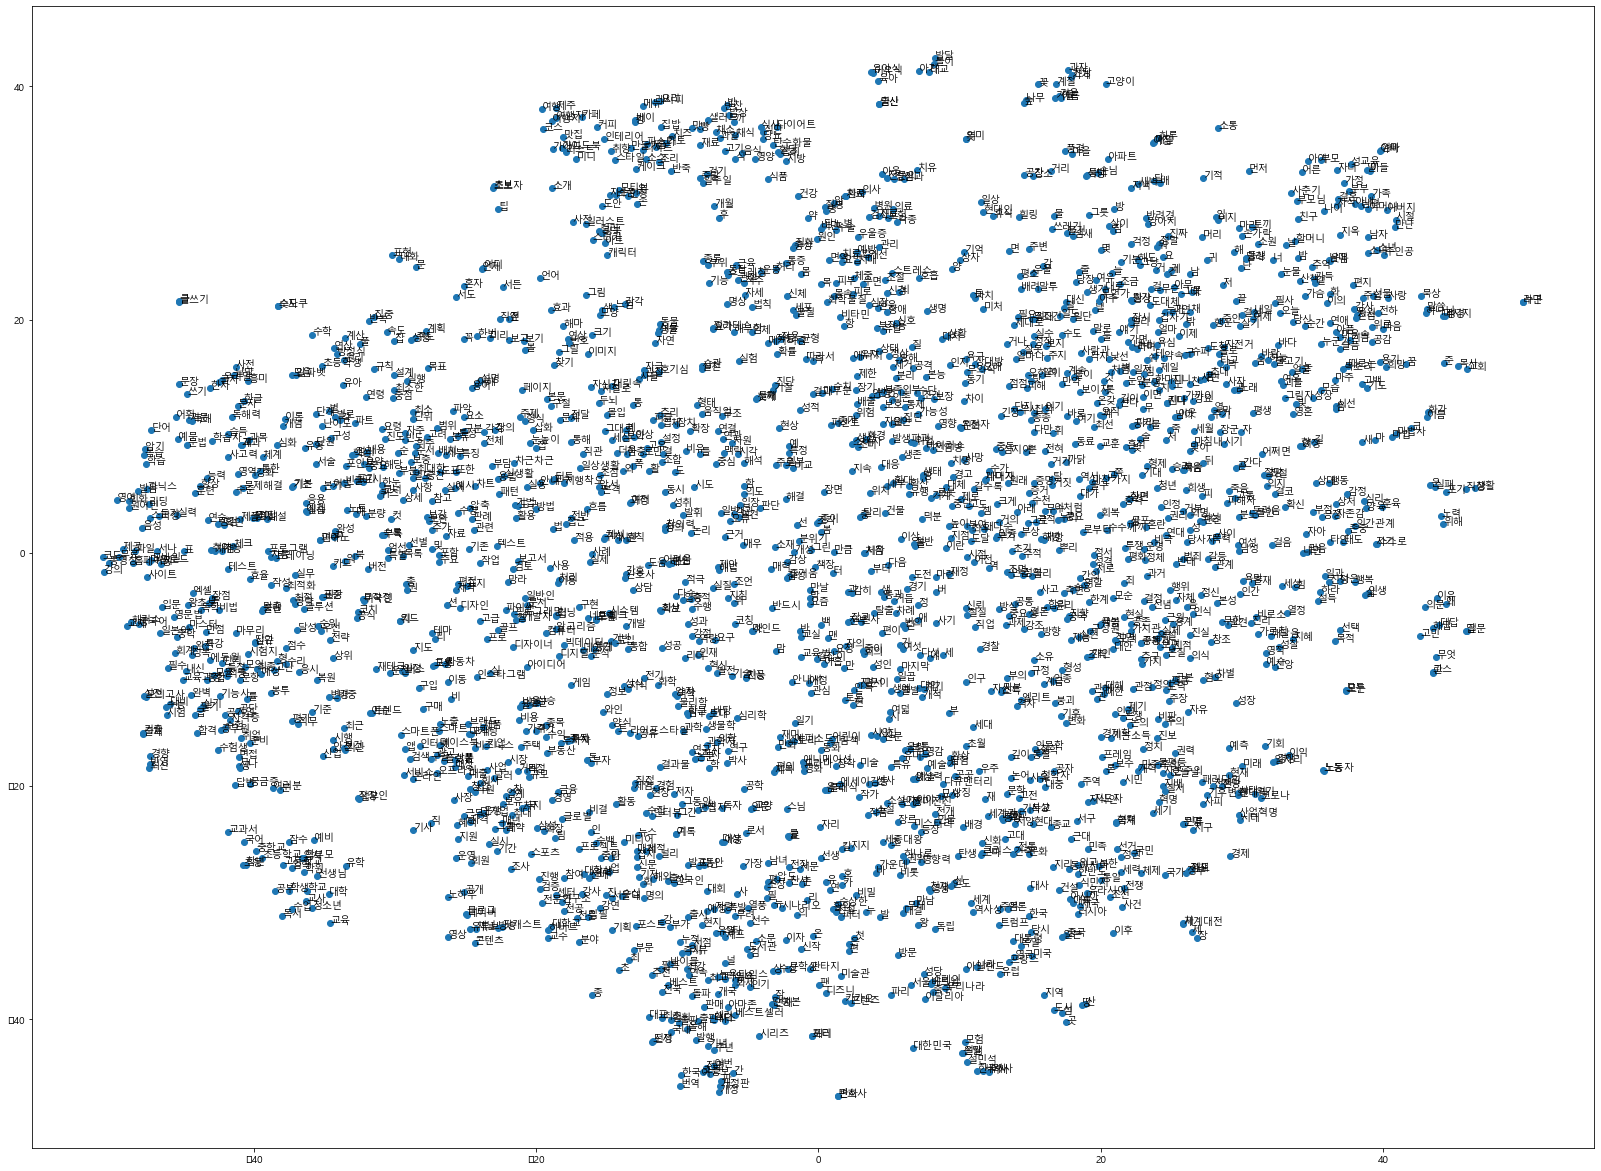

In [10]:
plt.rc('font', family='Malgun Gothic')

from sklearn.manifold import TSNE
from matplotlib import pyplot as plt

model2=TSNE(learning_rate=100)
transformed=model2.fit_transform(word_vectors_list)

xs2=transformed[:,0]
ys2=transformed[:,1]

plt.figure(figsize=(28,21))

plt.scatter(xs2,ys2)
for i,v in enumerate(vocabs):
    plt.annotate(v,xy=(xs2[i],ys2[i]))
    
plt.show()

In [54]:
return_doc=model.wv.most_similar(positive=['살인'])

return_doc

[('한편', 0.8266956806182861),
 ('충격', 0.8128359913825989),
 ('싸움', 0.7971022129058838),
 ('사건', 0.7957878112792969),
 ('공포', 0.7821958065032959),
 ('빚', 0.7714347243309021),
 ('목숨', 0.7696388363838196),
 ('남아', 0.7694854140281677),
 ('남자', 0.7515960335731506),
 ('범죄', 0.7512639164924622)]

### 3.4. document vectorize

In [11]:
model.init_sims(replace=True)

def document_vector(model,doc):
    doc=doc.split(' ')
    doc=[doc[i] for i in range(len(doc)) if doc[i] in vocabs]
    mean=0
    for i in range(len(doc)):
        mean+=model.wv[doc[i]]/len(doc)
    return mean

In [12]:
doc='살인 관련 추리 소설'

In [13]:
document_vector(model,df.text[1])

array([-0.00169415,  0.0272427 ,  0.00988166, -0.01978632, -0.01485894,
        0.00133197, -0.0156939 , -0.02365105, -0.00372069,  0.0358616 ,
        0.01566082, -0.00172551,  0.00900017,  0.01278446, -0.01087489,
        0.02192406, -0.02351937,  0.01981054, -0.02236061, -0.01835575,
        0.01298781, -0.00760314,  0.01785599,  0.01059041, -0.01375621,
       -0.00804245,  0.04098988,  0.01969635,  0.01058669, -0.00011577,
        0.03013799, -0.01931359,  0.00551968, -0.01543846, -0.04803877,
        0.01228889, -0.00615965, -0.05739505, -0.03179536,  0.01826433,
        0.02031713, -0.01200499, -0.09257626,  0.01020133, -0.00718251,
       -0.05979691,  0.01484901, -0.01659927,  0.0170282 , -0.00730415,
       -0.05768973,  0.01907279,  0.02191698, -0.00747024,  0.02453221,
        0.02798245,  0.0281287 ,  0.00998055,  0.01529319, -0.00625588,
       -0.00069289, -0.0059046 ,  0.01047361, -0.01766941,  0.02099755,
        0.00559124, -0.03514528, -0.01303609, -0.04920676, -0.02

### 3.5. cosine_similarity 함수 정의 및 유사 문서 검색 model 결과 확인

In [14]:
import math

def cos_sim(a,b):
    s=0.0
    s1=0.0
    s2=0.0
    for i in range(len(a)):
        s=s+a[i]*b[i]
        s1=s1+a[i]**2
        s2=s2+b[i]**2
    return s/math.sqrt(s1*s2)

In [15]:
def find_similarist_doc(model,doc):
    a=document_vector(model,doc)
    cos_vec=np.array([0.0]*len(df))
    for i in range(len(df)):
        b=document_vector(model,df.text[i])
        try:
            cos_vec[i]=-cos_sim(a,b)
        except:
            cos_vec[i]=0
    s=cos_vec.argsort()
    return (s[0],s[1],s[2],s[3],s[4])

In [142]:
document_vector(model,df.text[343])

0

In [17]:
doc='졸업 논문을 어떻게 하면 잘 쓸 수 있나요'

s=find_similarist_doc(model,doc)

for i in range(5):
    print(df.title[s[i]])

어떻게 말해줘야 할까 오은영의 현실밀착 육아회화
너무 신경썼더니 지친다 섬세하고 세심한 사람들을 위한 실전 안내서
3분 룰, 원하는 것을 얻는 말하기의 기술 상대의 뇌리에 꽂히는 메시지는 무엇이 다른가
프레임 나를 바꾸는 심리학의 지혜
마인드셋 스탠퍼드 인간 성장 프로젝트


## 4. Doc2Vec Model

### 4.1. tokenize

In [70]:
def tokenizer_okt_nouns(doc):
    return okt.nouns(doc)
df['token_text']=df['text'].apply(tokenizer_okt_nouns)

### 4.2. tagging

In [71]:
doc_df=df[['title','token_text']].values.tolist()
tagged_data=[TaggedDocument(words=_d,tags=[uid]) for uid,_d in doc_df]

### 4.3. 모델 생성 및 학습

In [72]:
max_epochs=100

model3=Doc2Vec(window=10,vector_size=150,alpha=0.025,min_alpha=0.025,min_count=100,dm=1,negative=5,seed=9999)

model3.build_vocab(tagged_data)

for epoch in range(max_epochs):
    model3.train(tagged_data,total_examples=model.corpus_count,epochs=model.epochs)
    model3.alpha-=0.002
    model3.min_alpha=model.alpha

### 4.4. 결과 확인

In [73]:
doc_list='히가시노 게이고의 살인 관련 추리 소설'.split(' ')

inferred_vector=model3.infer_vector(doc_list)
return_docs=model3.docvecs.most_similar(positive=[inferred_vector],topn=5)

for i in range(5):
    print(return_docs[i])

('영유아 몬테소리 육아대백과', 0.817439079284668)
('엄마 육아 공부 자질과 재능을 키워 자기 삶을 주도적으로 헤쳐나가는 사람으로 키우기', 0.7973767518997192)
('완전학습 바이블 배운 것을 100% 이해하는 후천적 공부머리의 비밀', 0.7891934514045715)
('아이를 위한 감정의 온도 엄마의 마음 관리법', 0.7878599166870117)
('알자배기 초등 복습 비법 공부력을 완성하는 초등 복습법의 모든 것', 0.776239275932312)


## 5. 시각화

1913.4516829533115


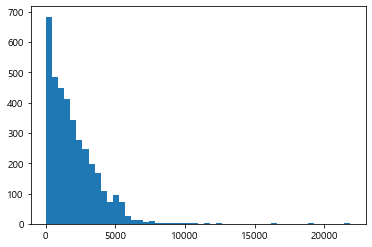

In [59]:
import pandas as pd
from matplotlib import pyplot as plt

df=pd.read_csv('./book_info(total).csv',encoding='utf-8')

len_text=[len(df.text[i]) for i in range(len(df))]

avg_len=0
n=0
for i in range(len(df)):
    if len(df.text[i])<10000:
        avg_len+=len(df.text[i])
        n=n+1
print(avg_len/n)
plt.hist(len_text,50)
plt.show()

In [64]:
print(len(df))

3691
